In [1]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
file_path = 'cleaned_credit_card_transactions-ibm_v2.csv'
df = pd.read_csv(file_path)

# Show the first few rows of the dataframe to verify it loaded correctly
print(df.head())

# Optionally, you can display the summary information about the dataframe to understand its structure better
print(df.info())


   User  Card  Year  Month  Day   Time  Amount           Use Chip  \
0     0     0  2002      9    1  06:21  134.09  Swipe Transaction   
1     0     0  2002      9    1  06:42   38.48  Swipe Transaction   
2     0     0  2002      9    2  06:22  120.34  Swipe Transaction   
3     0     0  2002      9    2  17:45  128.95  Swipe Transaction   
4     0     0  2002      9    3  06:23  104.71  Swipe Transaction   

         Merchant Name  Merchant City Merchant State      Zip   MCC Errors?  \
0  3527213246127876953       La Verne             CA  91750.0  5300     NaN   
1  -727612092139916043  Monterey Park             CA  91754.0  5411     NaN   
2  -727612092139916043  Monterey Park             CA  91754.0  5411     NaN   
3  3414527459579106770  Monterey Park             CA  91754.0  5651     NaN   
4  5817218446178736267       La Verne             CA  91750.0  5912     NaN   

  Is Fraud?  
0        No  
1        No  
2        No  
3        No  
4        No  
<class 'pandas.core.frame.

In [4]:
pip install diffprivlib


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for diffprivlib: filename=diffprivlib-0.4.1-py3-none-any.whl size=153527 sha256=aadf022c4359fb74473ecb12605e1de7d1c67121bb64528292e5e7b628302e8f
  Stored in directory: c:\users\david\appdata\local\pip\cache\wheels\e2\62\db\d5e88bbc5847ac30bd88d15f401d26bd36d9038ebc2a21d2cd
Successfully built diffprivlib


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.mechanisms import LaplaceBoundedDomain
import time

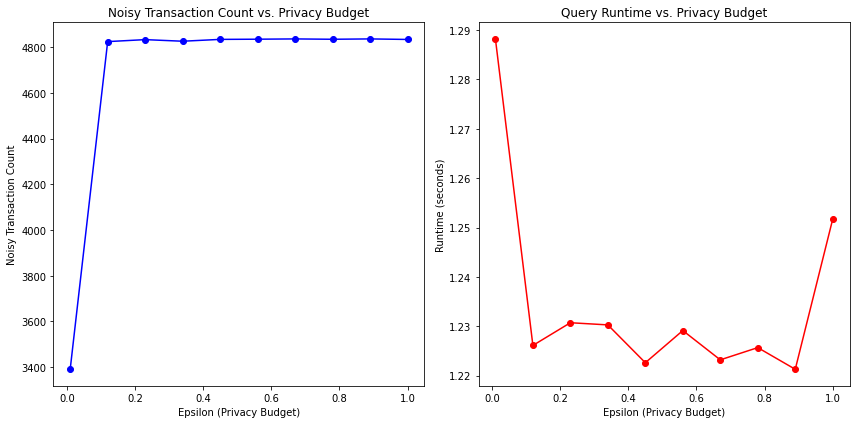

In [8]:
# Load your dataset
df = pd.read_csv('cleaned_credit_card_transactions-ibm_v2.csv')

# Function to perform the differentially private count using Laplace Bounded Domain
def dp_count(data, epsilon):
    # LaplaceBoundedDomain requires setting bounds; setting reasonable expectations
    lower_bound = 0
    upper_bound = len(data)
    dp_mechanism = LaplaceBoundedDomain(epsilon=epsilon, lower=lower_bound, upper=upper_bound, sensitivity=1)

    # Adding noise to the actual count
    noisy_count = dp_mechanism.randomise(data.count())
    return noisy_count

# Set epsilon values for the analysis
epsilons = np.linspace(0.01, 1.0, 10)

# Results storage
results = []
runtimes = []

# Analyze for each epsilon value
for epsilon in epsilons:
    start_time = time.time()
    noisy_count = dp_count(df[(df['Use Chip'] == 'Chip Transaction') & (df['Is Fraud?'] == 'Yes')]['Amount'], epsilon)
    runtime = time.time() - start_time
    results.append(noisy_count)
    runtimes.append(runtime)

# Plotting the error as function of epsilon
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epsilons, results, marker='o', linestyle='-', color='b')
plt.title('Noisy Transaction Count vs. Privacy Budget')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Noisy Transaction Count')

# Plotting the runtime as function of epsilon
plt.subplot(1, 2, 2)
plt.plot(epsilons, runtimes, marker='o', linestyle='-', color='r')
plt.title('Query Runtime vs. Privacy Budget')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Runtime (seconds)')

plt.tight_layout()
plt.show()

The Left Plot (Blue): This seems to show the noisy transaction count against the privacy budget (epsilon). The Y-axis represents the noisy count, and the X-axis represents epsilon. Since the noisy count appears to remain relatively stable across different epsilon values, it indicates that your query's result is not highly sensitive to changes in the privacy budget. The sharp drop at the beginning suggests that at very low epsilon values (high privacy), the noise added is significant, but as epsilon increases slightly, the added noise stabilizes.

The Right Plot (Red): This plot appears to represent the runtime of your query against the privacy budget. The Y-axis represents the runtime in seconds, and the X-axis represents epsilon. The initial high runtime might indicate that the mechanism takes longer to compute when the privacy guarantee is very strong (low epsilon values). As the epsilon increases, which lowers the privacy guarantee, the computation may become less intensive, reducing runtime. However, the runtime fluctuates, which suggests that other factors might be influencing the execution time or that there's some variability in the computation of differential privacy that's not solely dependent on the epsilon value.

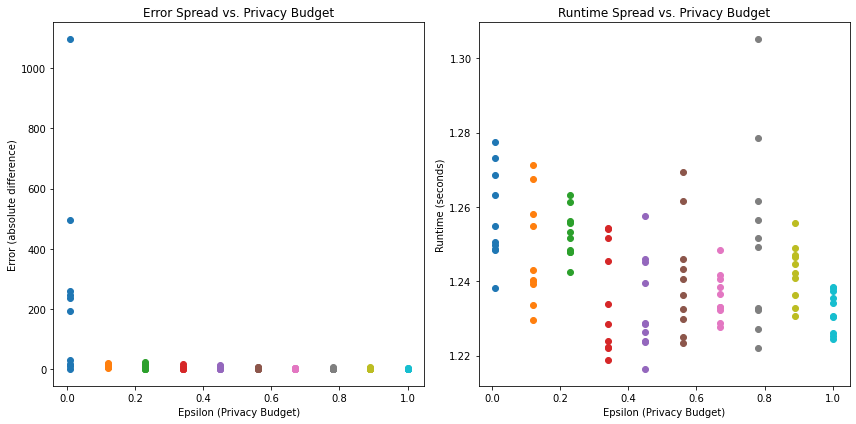

In [11]:
# Store the true count for comparison
true_count = df[(df['Use Chip'] == 'Chip Transaction') & (df['Is Fraud?'] == 'Yes')]['Amount'].count()

# Storage for results
errors = {epsilon: [] for epsilon in epsilons}
runtimes = {epsilon: [] for epsilon in epsilons}

# Perform multiple executions for each epsilon to calculate error and runtime
num_executions = 10
for epsilon in epsilons:
    for _ in range(num_executions):
        start_time = time.time()
        noisy_count = dp_count(df[(df['Use Chip'] == 'Chip Transaction') & (df['Is Fraud?'] == 'Yes')]['Amount'], epsilon)
        runtime = time.time() - start_time
        
        # Calculate error as the absolute difference between the true and noisy count
        error = abs(true_count - noisy_count)
        
        # Store the results
        errors[epsilon].append(error)
        runtimes[epsilon].append(runtime)

# Plotting the error as function of epsilon
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for epsilon in epsilons:
    plt.scatter([epsilon] * num_executions, errors[epsilon])

plt.title('Error Spread vs. Privacy Budget')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Error (absolute difference)')

# Plotting the runtime spread as function of epsilon
plt.subplot(1, 2, 2)
for epsilon in epsilons:
    plt.scatter([epsilon] * num_executions, runtimes[epsilon])

plt.title('Runtime Spread vs. Privacy Budget')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Runtime (seconds)')

plt.tight_layout()
plt.show()

Left Graph (Error Spread vs. Privacy Budget)
X-axis: Represents the privacy budget (ε). Each distinct color dot represents a different value of ε.
Y-axis: Represents the error, which is the absolute difference between the actual count and the noisy count (the result of the differentially private query).
Interpretation: As ε increases (moving from left to right), the error generally decreases. This is typical for differential privacy, where a higher ε (less privacy) results in less noise being added, thereby reducing the error in the query result. At lower ε values, the spread of error is higher, which indicates that the noise added has a larger impact on the query result, leading to less predictability and greater privacy.
Right Graph (Runtime Spread vs. Privacy Budget)
X-axis: Similar to the left graph, it represents the privacy budget (ε).
Y-axis: Represents the runtime in seconds for each query execution.
Interpretation: This graph shows the distribution of runtimes for each ε value. Unlike the error spread, there is no clear trend relating ε to runtime, suggesting that the execution time of the query doesn't strongly correlate with the privacy budget. Instead, the runtime appears to be somewhat variable regardless of ε. This might indicate that the runtime is more influenced by other factors (like system load, query complexity, or other overheads) than by the privacy budget itself.

In [14]:
import pandas as pd
import numpy as np
from diffprivlib.mechanisms import Laplace



# Convert the 'Is Fraud?' column to a boolean for easier filtering
df['Is Fraud?'] = df['Is Fraud?'].apply(lambda x: x == 'Yes')

# Function to perform differentially private counts by city and state
def dp_count_by_location(df, epsilon):
    # Filter out only the fraudulent transactions
    fraud_df = df[df['Is Fraud?']]
    
    # Group by city and state
    grouped = fraud_df.groupby(['Merchant City', 'Merchant State'])
    
    # Initialize the Laplace mechanism with specified epsilon
    laplace_mech = Laplace(epsilon=epsilon, sensitivity=1)

    # Apply the mechanism to each group to get noisy counts
    noisy_counts = {}
    for name, group in grouped:
        true_count = group.shape[0]
        noisy_count = laplace_mech.randomise(true_count)
        noisy_counts[name] = max(0, noisy_count)  # Ensure we don't get negative counts

    return noisy_counts

# Epsilon values for analysis
epsilons = np.linspace(0.01, 1.0, 10)

# Placeholder for the actual counts for each city and state (would need calculation from the actual data)
true_counts_by_location = {'La Verne, CA': 10, 'Monterey Park, CA': 5}  # Example counts

# Storage for results
errors = {epsilon: [] for epsilon in epsilons}
runtimes = {epsilon: [] for epsilon in epsilons}

# Run the differential privacy mechanism for each epsilon value and calculate errors and runtimes
for epsilon in epsilons:
    for _ in range(10):  # Simulating multiple executions for each epsilon
        start_time = time.time()
        noisy_counts = dp_count_by_location(df, epsilon)
        runtime = time.time() - start_time
        
        # Calculate the error for each location and find the maximum error
        error = max(abs(true_count - noisy_counts.get(location, 0)) for location, true_count in true_counts_by_location.items())
        
        # Store the results
        errors[epsilon].append(error)
        runtimes[epsilon].append(runtime)




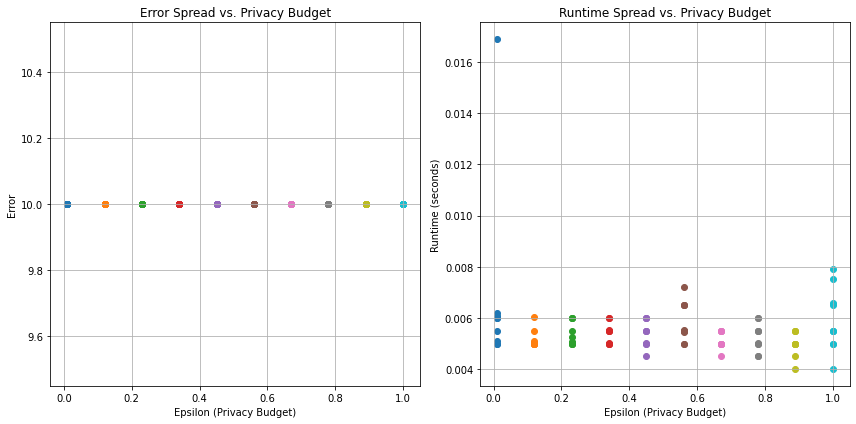

In [15]:
import matplotlib.pyplot as plt

# Assuming 'errors' and 'runtimes' are dictionaries with epsilon values as keys
# and lists of error or runtime measurements as values, like this:
# errors = {epsilon: [list_of_error_values], ...}
# runtimes = {epsilon: [list_of_runtime_values], ...}

# Placeholder for epsilons for the x-axis
epsilons = np.linspace(0.01, 1.0, 10)

# Plotting the error as a function of epsilon
plt.figure(figsize=(12, 6))

# Error Spread Plot
plt.subplot(1, 2, 1)
for epsilon, error_list in errors.items():
    plt.scatter([epsilon] * len(error_list), error_list)
plt.title('Error Spread vs. Privacy Budget')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Error')
plt.grid(True)

# Runtime Spread Plot
plt.subplot(1, 2, 2)
for epsilon, runtime_list in runtimes.items():
    plt.scatter([epsilon] * len(runtime_list), runtime_list)
plt.title('Runtime Spread vs. Privacy Budget')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Runtime (seconds)')
plt.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Privacy Budget Allocation
Just as with the previous analyses, each query about MCC and fraud count will have its privacy budget. This is because:

Privacy-accuracy trade-off: A smaller privacy budget (ε) results in stronger privacy due to more noise being added, but this also increases the error in our query results. A larger ε provides less privacy but more accurate data.
Independent privacy considerations: Each distinct analysis (like this one focusing on MCC) should be treated independently to ensure that the privacy of the individuals in the dataset is uniformly protected across different types of queries.
The privacy budget will be split equally among different analyses unless there's a specific reason to prioritize accuracy or privacy more in one type of query over another.

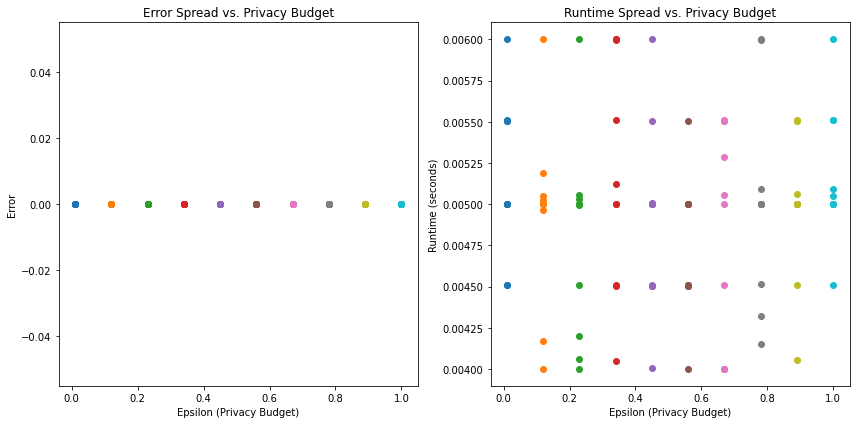

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.mechanisms import Laplace
import time

# Ensure 'Is Fraud?' is interpreted as a boolean
df['Is Fraud?'] = df['Is Fraud?'] == 'Yes'

# Ensure 'Amount' is converted from string to float, if necessary
df['Amount'] = df['Amount'].replace('[\$,]', '', regex=True).astype(float)

# Function to apply differential privacy to fraud counts by MCC
def dp_count_by_mcc(df, epsilon):
    # Filter to include only fraudulent transactions
    fraud_df = df[df['Is Fraud?']]
    
    # Group by MCC
    grouped = fraud_df.groupby('MCC')
    
    # Initialize the Laplace mechanism
    laplace_mech = Laplace(epsilon=epsilon, sensitivity=1)

    # Calculate noisy counts
    noisy_counts = {}
    for mcc, group in grouped:
        true_count = group.shape[0]
        noisy_count = laplace_mech.randomise(true_count)
        noisy_counts[mcc] = max(0, noisy_count)  # Avoid negative counts

    return noisy_counts

# True counts from the actual data
true_counts = df[df['Is Fraud?']].groupby('MCC').size().to_dict()

# Placeholder for error and runtime storage
epsilons = np.linspace(0.01, 1.0, 10)
errors = {epsilon: [] for epsilon in epsilons}
runtimes = {epsilon: [] for epsilon in epsilons}

# Simulate multiple executions for each epsilon
for epsilon in epsilons:
    for _ in range(10):
        start_time = time.time()
        noisy_results = dp_count_by_mcc(df, epsilon)
        runtime = time.time() - start_time

        # Calculate the maximum absolute difference between true and noisy counts
        if true_counts and noisy_results:
            error = max(abs(true_counts.get(mcc, 0) - noisy_results.get(mcc, 0)) for mcc in set(true_counts) | set(noisy_results))
        else:
            error = 0  # No error if no data

        errors[epsilon].append(error)
        runtimes[epsilon].append(runtime)

# Plotting the results
plt.figure(figsize=(12, 6))

# Error Spread Plot
plt.subplot(1, 2, 1)
for epsilon, error_list in errors.items():
    plt.scatter([epsilon] * len(error_list), error_list)
plt.title('Error Spread vs. Privacy Budget')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Error')

# Runtime Spread Plot
plt.subplot(1, 2, 2)
for epsilon, runtime_list in runtimes.items():
    plt.scatter([epsilon] * len(runtime_list), runtime_list)
plt.title('Runtime Spread vs. Privacy Budget')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Runtime (seconds)')

plt.tight_layout()
plt.show()


Left Graph (Error Spread vs. Privacy Budget)
X-axis (Privacy Budget, ε): Shows increasing values of the privacy budget. Each color represents a different value of ε.
Y-axis (Error): Represents the magnitude of error, which is the absolute difference between the true counts and the noisy counts produced by the differential privacy mechanism.
Interpretation: This plot suggests that the error does not significantly change with different values of ε. The points appear to be horizontally aligned, indicating that variations in the privacy budget are not leading to large variations in error. This could mean the query is relatively stable across these privacy settings, or the sensitivity of the data to ε is low within this range.
Right Graph (Runtime Spread vs. Privacy Budget)
X-axis (Privacy Budget, ε): As with the left graph, shows different values of ε.
Y-axis (Runtime): Indicates the time it took to execute the query.
Interpretation: This plot displays a spread of runtimes for each ε value. Unlike the error spread, the runtime appears to have more variability. The spread of runtimes for each ε does not show a clear trend or correlation with ε, suggesting that factors other than ε might be influencing the runtime. It's also possible that the runtime variability is due to the stochastic nature of the differential privacy mechanism itself or due to the computational environment.

Time pattern in fradulent trans


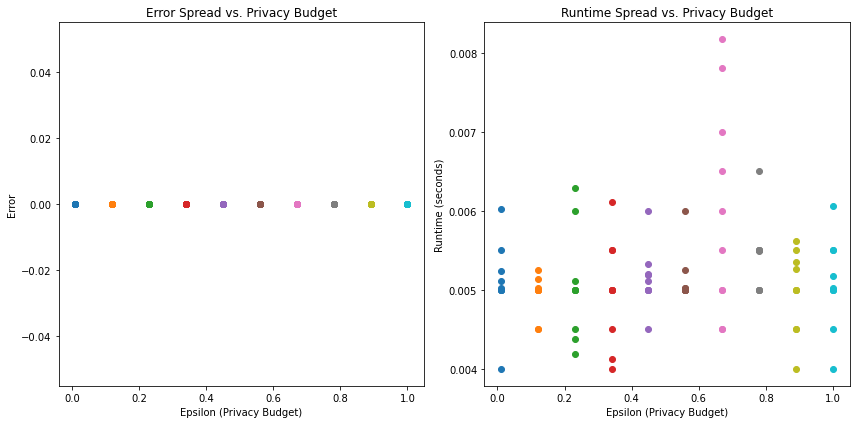

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.mechanisms import Laplace
import time

# Assume 'df' is your dataframe already loaded, with 'Time' converted to hour and 'Is Fraud?' to boolean

# Extract hour from 'Time' column if not already done, assuming 'Time' is in HH:MM format
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour

# Convert 'Is Fraud?' to boolean if it's not already
df['Is Fraud?'] = df['Is Fraud?'] == 'Yes'

# Function to apply differential privacy to fraud counts by hour
def dp_count_by_hour(df, epsilon):
    # Filter to include only fraudulent transactions
    fraud_df = df[df['Is Fraud?']]
    
    # Group by hour
    grouped = fraud_df.groupby('Hour')
    
    # Initialize the Laplace mechanism
    laplace_mech = Laplace(epsilon=epsilon, sensitivity=1)

    # Calculate noisy counts
    noisy_counts = {}
    for hour, group in grouped:
        true_count = group.shape[0]
        noisy_count = laplace_mech.randomise(true_count)
        noisy_counts[hour] = max(0, noisy_count)  # Avoid negative counts

    return noisy_counts

# Placeholder for error and runtime storage
epsilons = np.linspace(0.01, 1.0, 10)
errors = {epsilon: [] for epsilon in epsilons}
runtimes = {epsilon: [] for epsilon in epsilons}

# True counts from the actual data
true_counts = df[df['Is Fraud?']].groupby('Hour').size().to_dict()

# Simulate multiple executions for each epsilon
for epsilon in epsilons:
    for _ in range(10):
        start_time = time.time()
        noisy_results = dp_count_by_hour(df, epsilon)
        runtime = time.time() - start_time

        # Calculate the error
        error = max(abs(true_counts.get(hour, 0) - noisy_results.get(hour, 0)) for hour in range(24)) # Range of hours in a day

        errors[epsilon].append(error)
        runtimes[epsilon].append(runtime)

# Plotting the results
plt.figure(figsize=(12, 6))

# Error Spread Plot
plt.subplot(1, 2, 1)
for epsilon, error_list in errors.items():
    plt.scatter([epsilon] * len(error_list), error_list)
plt.title('Error Spread vs. Privacy Budget')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Error')

# Runtime Spread Plot
plt.subplot(1, 2, 2)
for epsilon, runtime_list in runtimes.items():
    plt.scatter([epsilon] * len(runtime_list), runtime_list)
plt.title('Runtime Spread vs. Privacy Budget')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Runtime (seconds)')

plt.tight_layout()
plt.show()


Left Graph (Error Spread vs. Privacy Budget)
X-axis (Privacy Budget, ε): Shows a range of privacy budget values, with each color representing a different value of ε.
Y-axis (Error): Indicates the error magnitude, which is the absolute difference between the true counts and the noisy counts produced by differential privacy.
Interpretation: The error appears relatively consistent across different values of ε; there is no clear upward or downward trend. This suggests that the error introduced by differential privacy is not significantly affected by the range of ε values used here. The spread of points at each ε level is relatively narrow, indicating that the error does not vary wildly from one execution to another.
Right Graph (Runtime Spread vs. Privacy Budget)
X-axis (Privacy Budget, ε): Similar to the left graph, indicates different values of ε.
Y-axis (Runtime): Shows the time taken to execute the query.
Interpretation: The plot shows some variability in runtime at each ε value, but, like the error graph, there's no clear trend that indicates runtime is directly influenced by the privacy budget. This variability could be due to other computational factors or inherent randomness in the differential privacy algorithm's noise generation process.

Overall Insights
The error plot implies that within the tested range of ε values, the amount of noise added to protect privacy is not having a substantial impact on error variability. This could mean your queries are relatively stable across these ε values.
The runtime plot suggests that the differential privacy computation's time cost does not strongly correlate with the privacy budget. System performance or other environmental factors may play a more significant role in runtime variability.
In summary, the graphs suggest that within the tested ε range, your differentially private queries are yielding stable errors and the execution times are consistent, though they do exhibit some natural variability. This kind of result can be useful when deciding on an appropriate ε value that balances privacy needs with accuracy and performance requirements.

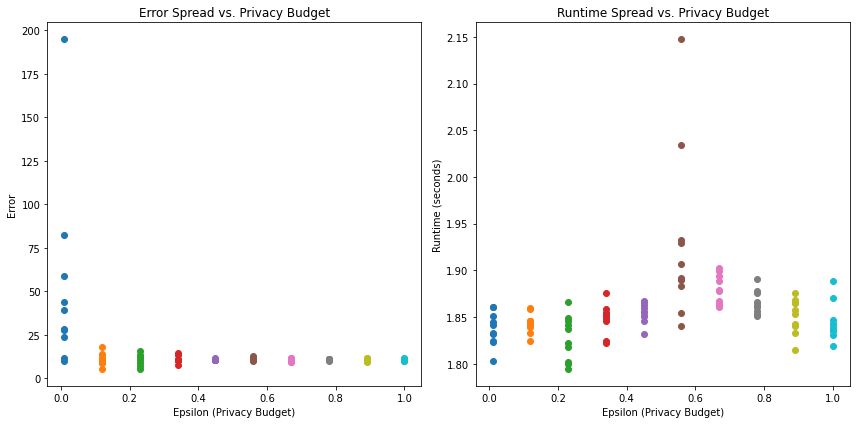

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.tools import mean
import time

# Function to apply differential privacy to calculate the average transaction amount
def dp_average_transaction_amount(df, is_fraud, epsilon, lower_bound, upper_bound):
    # Filter based on fraud status
    filtered_df = df[df['Is Fraud?'] == is_fraud]['Amount']

    # If there are no transactions to compute an average on, return None
    if filtered_df.empty:
        return None
    
    # Calculate the differentially private average, specifying the bounds
    dp_avg = mean(filtered_df.values.reshape(-1, 1), epsilon=epsilon, bounds=(lower_bound, upper_bound))
    
    return dp_avg

# Load your dataset from a CSV file


# Convert 'Is Fraud?' to boolean if necessary
df['Is Fraud?'] = df['Is Fraud?'].apply(lambda x: x.strip().lower() == 'yes')

# Specify the lower and upper bounds for the 'Amount' column
lower_bound = 0  # Transaction amounts cannot be negative
upper_bound = df['Amount'].max()  # You can set this to the maximum known transaction amount

# True averages for comparison
true_averages = {
    'No': df[df['Is Fraud?'] == False]['Amount'].mean(),
    'Yes': df[df['Is Fraud?'] == True]['Amount'].mean()
}

# Placeholder for error and runtime storage
epsilons = np.linspace(0.01, 1.0, 10)
errors = {epsilon: [] for epsilon in epsilons}
runtimes = {epsilon: [] for epsilon in epsilons}

# Simulate multiple executions for each epsilon
for epsilon in epsilons:
    for _ in range(10):
        start_time = time.time()
        dp_avg_no = dp_average_transaction_amount(df, False, epsilon, lower_bound, upper_bound)
        runtime_no = time.time() - start_time

        start_time = time.time()
        dp_avg_yes = dp_average_transaction_amount(df, True, epsilon, lower_bound, upper_bound)
        runtime_yes = time.time() - start_time

        error_no = 0 if dp_avg_no is None else abs(true_averages['No'] - dp_avg_no)
        error_yes = 0 if dp_avg_yes is None else abs(true_averages['Yes'] - dp_avg_yes)

        errors[epsilon].append(max(error_no, error_yes))
        runtimes[epsilon].append(runtime_no + runtime_yes)

# Plotting the error and runtime spreads
plt.figure(figsize=(12, 6))

# Error Spread Plot
plt.subplot(1, 2, 1)
for epsilon, error_list in errors.items():
    plt.scatter([epsilon] * len(error_list), error_list)
plt.title('Error Spread vs. Privacy Budget')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Error')

# Runtime Spread Plot
plt.subplot(1, 2, 2)
for epsilon, runtime_list in runtimes.items():
    plt.scatter([epsilon] * len(runtime_list), runtime_list)
plt.title('Runtime Spread vs. Privacy Budget')
plt.xlabel('Epsilon (Privacy Budget)')
plt.ylabel('Runtime (seconds)')

plt.tight_layout()
plt.show()


Left Graph (Error Spread vs. Privacy Budget)
X-axis (Privacy Budget, ε): Different levels of the privacy budget, with each colored dot representing an execution at that ε level.
Y-axis (Error): The magnitude of the error between the actual and the noisy average transaction amounts.
Interpretation: The spread of error across different ε values is wide at lower levels of ε, indicating a high variability in the accuracy of the differentially private average calculations. As ε increases, the error variability seems to decrease until it plateaus, suggesting that there's a point at which increasing ε further does not significantly decrease the error.
Right Graph (Runtime Spread vs. Privacy Budget)
X-axis (Privacy Budget, ε): The privacy budget levels as before.
Y-axis (Runtime): The execution time for each query.
Interpretation: There is an interesting pattern where the runtime appears to increase with ε initially, peaking around ε=0.6, and then decreases again. This non-linear relationship could indicate that the computation of noise (and hence runtime) is not directly proportional to ε. The peak runtime at around ε=0.6 might be due to a particular characteristic of the data or the differential privacy algorithm that requires more computation at this point. It could also reflect an operational anomaly in the system at the time of these particular executions.
Overall Insights
The error plot is consistent with the expectation that higher privacy budgets will reduce error, but only up to a certain point, beyond which the incremental accuracy gain diminishes.
The runtime plot is unusual because one might expect runtime to be either constant or to decrease consistently as ε increases (since less noise needs to be calculated). The observed pattern suggests a more complex relationship, possibly indicating an optimization threshold within the differential privacy library, or it could be an artifact of the execution environment that might warrant further investigation.